# Comparison with other algorithms

## Loading libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import time

## Loading Dataset

In [5]:
data = pd.read_csv('C:\data\clean-data.csv', index_col=False)
data.drop('Unnamed: 0',axis=1, inplace=True)

In [3]:
print(data.shape)

(569, 31)


Let's take a look at the number of Benign and Maglinant cases from the dataset. From the output shown below, majority of the cases are benign (0).

In [6]:
print(data.groupby('diagnosis').size())

diagnosis
B    357
M    212
dtype: int64


It is good to check the correlations between the attributes. From the output graph below, The red around the diagonal suggests that attributes are correlated with each other. The yellow and green patches suggest some moderate correlation and the blue boxes show negative correlations.

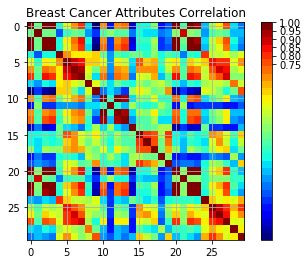

In [7]:
from matplotlib import cm as cm

fig = plt.figure()
ax1 = fig.add_subplot(111)
cmap = cm.get_cmap('jet', 30)
cax = ax1.imshow(data.corr(), interpolation="none", cmap=cmap)
ax1.grid(True)
plt.title('Breast Cancer Attributes Correlation')
# Add colorbar, make sure to specify tick locations to match desired ticklabels
fig.colorbar(cax, ticks=[.75,.8,.85,.90,.95,1])
plt.show()

In [8]:
Y = data['diagnosis'].values
X = data.drop('diagnosis', axis=1).values

X_train, X_test, Y_train, Y_test = train_test_split (X, Y, test_size = 0.20, random_state=21)

### The following non-linear algorithms will be used, namely: Classification and Regression Trees (CART), Gaussian Naive Bayes (NB) and k-Nearest Neighbors (KNN).

In [11]:
models_list = []
models_list.append(('CART', DecisionTreeClassifier()))
models_list.append(('SVM', SVC())) 
models_list.append(('NB', GaussianNB()))
models_list.append(('KNN', KNeighborsClassifier()))

In [12]:
num_folds = 10
results = []
names = []

for name, model in models_list:
    kfold = KFold(n_splits=num_folds, random_state=123)
    start = time.time()
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    end = time.time()
    results.append(cv_results)
    names.append(name)
    print( "%s: %f (%f) (run time: %f)" % (name, cv_results.mean(), cv_results.std(), end-start))

CART: 0.923140 (0.034533) (run time: 0.090059)
SVM: 0.619614 (0.082882) (run time: 0.435587)
NB: 0.940773 (0.033921) (run time: 0.025961)
KNN: 0.927729 (0.055250) (run time: 0.041718)


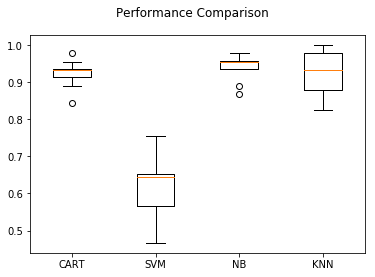

In [13]:
fig = plt.figure()
fig.suptitle('Performance Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

From the initial run, it looks like GaussianNB, KNN and CART performed the best given the dataset (all above 92% mean accuracy). Support Vector Machine has a surprisingly bad performance here. However, if we standardise the input dataset, it's performance should improve.

## Evaluation of algorithm on Standardised Data

The performance of the few machine learning algorithm could be improved if a standardised dataset is being used. The improvement is likely for all the models. I will use pipelines that standardize the data and build the model for each fold in the cross-validation test harness. That way we can get a fair estimation of how each model with standardized data might perform on unseen data.

In [14]:
import warnings

# Standardize the dataset
pipelines = []

pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART',
                                                                        DecisionTreeClassifier())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC( ))])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB',
                                                                      GaussianNB())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN',
                                                                       KNeighborsClassifier())])))
results = []
names = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    kfold = KFold(n_splits=num_folds, random_state=123)
    for name, model in pipelines:
        start = time.time()
        cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
        end = time.time()
        results.append(cv_results)
        names.append(name)
        print( "%s: %f (%f) (run time: %f)" % (name, cv_results.mean(), cv_results.std(), end-start))

ScaledCART: 0.923092 (0.042188) (run time: 0.095043)
ScaledSVM: 0.964879 (0.038621) (run time: 0.095012)
ScaledNB: 0.931932 (0.038625) (run time: 0.040649)
ScaledKNN: 0.958357 (0.038595) (run time: 0.067400)


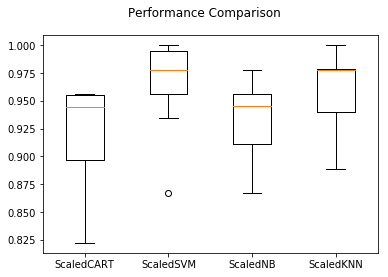

In [15]:
fig = plt.figure()
fig.suptitle('Performance Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Notice the drastic improvement of SVM after using scaled data.